# Implementation of Feature Models

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Read Wholesale Data

## Features

Parent features
* Channel, Region

Child features
* Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen

In [2]:
PATH = "data/wholesale.csv"

df = pd.read_csv(PATH)
display(df)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


# Gaussian Mixture Model

The Gaussian mixture model (GMM) is a probabilistic model for representing normally distributed subpopulations within an overall population. A Gaussian mixture model is parameterized by the mixture component weights, means and covariances. Clusters are modelled as Gaussians not just by their mean but their covariances. The Expectation-Maximisation algorithm assigns data to each cluster with a probability. The GMM gives a probability model of x, a “generative” model.

#### Joint probability distribution

![title](asset/gmm_def.png)

#### Latent variable form, sampling from P(x):

![LVM](asset/gmm_lvm.png)

#### Maximum Likelihood estimates

![MLE](asset/gmm_mle.png)

#### Expectation Maximisation (EM) Algorithm

* E-step (Expectation): For each datum x_i, compute r_ic, probability that it belongs to cluster c:

    * Compute its probability under model c
    * Normalise to sum to one (over clusters c)
    
    ![E step](asset/gmm_e_step.png)

* M-step (Maximisation): For each cluster z=c, update its parameters using the (weighted) data points

![M_step](asset/gmm_m_step.png)

#### Log Likelihood

Each step of the EM algorithm increases the log-likelihood of the GMM, and convergence is guaranteed as another Coordinate Ascent method.

![Log_likelihood](asset/gmm_log_likelihood.png)

#### Variational Inference

Each parameter is replaced from a point to a probability distribution, called the “variational posterior”. The Kullback-Leibler divergence is minimised between the true value and the estimate. Each component’s mean, standard deviation and weight are modelled by the normal, inverse gamma and Dirichlet distributions respectively. Because the gamma distribution is often used as a posterior for the precision and the precision is the reciprocal of the variance, the variational posterior for the variance can be modelled by the inverse gamma distribution. The probability of a data point being generated by any of the components is modelled with a categorical distribution, and the likelihood of a datapoint is determined by the corresponding mixture component’s multivariate normal distribution.

#### Variational Inference v.s. Expectation Maximisation

Expectation maximisation provides a point estimate while variational inference provides the posterior distribution. Expectation maximisation does not have any measure of uncertainty that the measure conveys with it.

#### No. of Components

The number of components in the Gaussian mixture model is a hyperparameter, initialised by either held-out data using log-likelihood or info-theoretic criteria such as Bayesian information criterion (BIC) or Akaike information criterion (AIC), in the absence of external cues, with an assumption of independently and identically distributed (i.i.d.) data.

#### Posteriori component assignment probability

The posteriori component assignment probability can be estimated using Bayes’ theorem and the estimated model parameters. The probability that a data point x belongs to component C_i is calculated using Bayes’ theorem:

![title](asset/gmm_cond.png)

#### Class-conditional GMM

A class-conditional Gaussian mixture model can be useful for class-conditional classification. Learning by fitting the Gaussian to data in each class gives P(position|class). To perform inference, the Bayes’ rule is employed where P(class|position) is proportional to P(position|class)P(class).

The conditional distribution for a Gaussian mixture model is defined as:
  
![title](asset/gmm_class_cond.png)


In [3]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


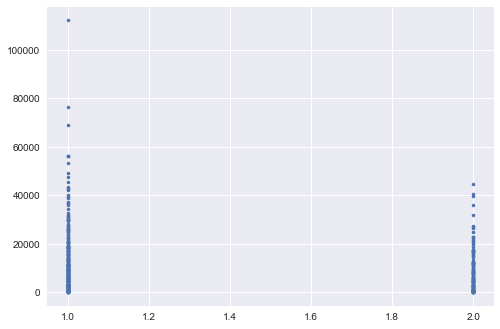

In [4]:
"""Tensorflow Implementation, using Variational Inference
VI vs EM: https://www.quora.com/When-should-I-use-variational-inference-vs-expectation-maximization-for-fitting-a-Gaussian-mixture-model
"""

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

X = df[['Channel', 'Fresh']].values
X = X.astype(np.float32)
N = len(X)

plt.plot(X[:,0], X[:,1], '.')
plt.show()

# TF Dataset
batch_size = 440
dataset = tf.data.Dataset.from_tensor_slices(
    (X)).shuffle(440).batch(batch_size)

In [5]:
class GaussianMixtureModel(tf.keras.Model):
    """Bayesian Gaussian mixture model.
    
    Parameters:
    - Nc: int > 0, Number of mixture components.
    - Nd: int > 0, Number of dimensions.
        
    Assumption:
    - Gaussians' variances in each dimension are independent.
    """
      
    def __init__(self, Nc, Nd):
        # Initialize
        super(GaussianMixtureModel, self).__init__()
        self.Nc = Nc
        self.Nd = Nd
        
        # Variational distribution variables for means
        self.locs = tf.Variable(tf.random.normal((Nc, Nd)))
        self.scales = tf.Variable(tf.pow(tf.random.gamma((Nc, Nd), 5, 5), -0.5))
        
        # Variational distribution variables for standard deviations
        self.alpha = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        self.beta = tf.Variable(tf.random.uniform((Nc, Nd), 4., 6.))
        
        # Variational distribution variables for component weights
        self.counts = tf.Variable(2*tf.ones((Nc,)))

        # Prior distributions for the means
        self.mu_prior = tfd.Normal(tf.zeros((Nc, Nd)), tf.ones((Nc, Nd)))

        # Prior distributions for the standard deviations
        self.sigma_prior = tfd.Gamma(5*tf.ones((Nc, Nd)), 5*tf.ones((Nc, Nd)))
        
        # Prior distributions for the component weights
        self.theta_prior = tfd.Dirichlet(2*tf.ones((Nc,)))
        
        
        
    def call(self, x, sampling=True):
        """Compute losses given a batch of data.
        
        Parameters:
        - x: tf.Tensor, Data batch
        - sampling: bool, Sample from variational posterior distributions
                    or mean of variational distributions.            
        
        Returns:
        - log_likelihoods: tf.Tensor, Log likelihood for each sample
        - kl_sum : tf.Tensor, Sum of the KL divergences between the variational
                   distributions and their priors
        """
        
        # The variational distributions
        mu = tfd.Normal(self.locs, self.scales)
        sigma = tfd.Gamma(self.alpha, self.beta)
        theta = tfd.Dirichlet(self.counts)
        
        # Sample from the variational distributions
        if sampling:
            Nb = x.shape[0]  # no. of samples in the batch
            mu_sample = mu.sample(Nb)
            sigma_sample = tf.pow(sigma.sample(Nb), -0.5)
            theta_sample = theta.sample(Nb)
        else:
            mu_sample = tf.reshape(mu.mean(), (1, self.Nc, self.Nd))
            sigma_sample = tf.pow(tf.reshape(sigma.mean(), (1, self.Nc, self.Nd)), -0.5)
            theta_sample = tf.reshape(theta.mean(), (1, self.Nc))
        
        # The mixture density
        density = tfd.Mixture(
            cat=tfd.Categorical(probs=theta_sample),
            components=[
                tfd.MultivariateNormalDiag(loc=mu_sample[:, i, :],
                                           scale_diag=sigma_sample[:, i, :])
                for i in range(self.Nc)])
                
        # Compute the mean log likelihood
        log_likelihoods = density.log_prob(x)
        
        # Compute the KL divergence sum
        mu_div    = tf.reduce_sum(tfd.kl_divergence(mu,    self.mu_prior))
        sigma_div = tf.reduce_sum(tfd.kl_divergence(sigma, self.sigma_prior))
        theta_div = tf.reduce_sum(tfd.kl_divergence(theta, self.theta_prior))
        kl_sum = mu_div + sigma_div + theta_div
        
        # Return both losses
        return log_likelihoods, kl_sum
    
    def get_losses(self, X):
        log_likelihoods, kl_sum = self.call(data)
        elbo_loss = kl_sum/N - tf.reduce_mean(log_likelihoods)
        return log_likelihoods, kl_sum, elbo_loss

In [6]:
# A GMM with 3 components in 2 dimensions
c = 2
d = 2
model = GaussianMixtureModel(c, d)

# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

# Minimise the negative evidence lower bound (ELBO)
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods, kl_sum = model(data)
        elbo_loss = kl_sum/N - tf.reduce_mean(log_likelihoods)
    tvars = model.trainable_variables
    gradients = tape.gradient(elbo_loss, tvars)
    optimizer.apply_gradients(zip(gradients, tvars))
    
# Fit the model
EPOCHS = 1000
for epoch in range(EPOCHS):
    for data in dataset:
        train_step(data)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


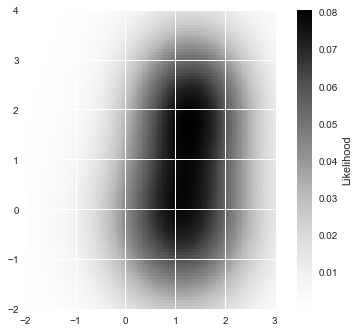

In [7]:
# Compute log likelihood at each point on a grid
Np = 100 #number of grid points
x1, x2, y1, y2 = -2, 3, -2 , 4

Xp, Yp = np.meshgrid(np.linspace(x1, x2,Np), np.linspace(y1, y2,Np))
Pp = np.column_stack([Xp.flatten(), Yp.flatten()])
Z, _ = model(Pp.astype('float32'), sampling=False)
Z = np.reshape(Z, (Np, Np))
        
# Show the fit mixture density
plt.imshow(np.exp(Z),
           extent=(x1, x2, y1, y2),
           origin='lower')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Likelihood')
plt.show()

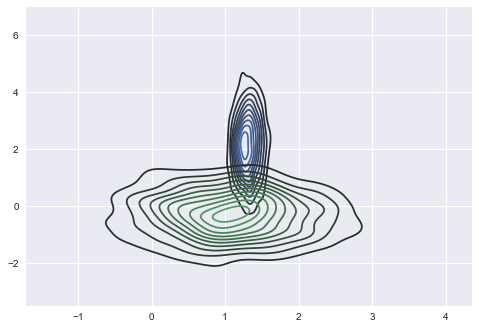

In [8]:
# Sample from the mean variational posterior
means = tfd.Normal(model.locs, model.scales).sample(1000)

# Plot the mean samples for a single
for i in range(c):
    sns.kdeplot(means[:, i, 0].numpy(),
            means[:, i, 1].numpy(),
            n_levels=10)
plt.show()

# Mixture Density Network

Ref: https://www.katnoria.com/mdn/

For each input x, predict a probability density function (pdf) of $P(Y=y|X=x)$ that is a probability weighted sum of smaller Gaussian probability distributions.


$$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \mathcal{N}(y|\mu_{k}(x), \sigma_{k}^{2}(x))$$

Each parameter $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ is approximated by a neural network as a function of input $x$:

$$Z = W_{o} \tanh( W_{h} X + b_{h}) + b_{o}$$

where 

$$\Pi_{k} = \frac{\exp(Z_{k})}{\sum exp(Z)}, \sigma = \exp(Z), \mu = Z$$

The loss function with respect to component weights $w$ is given by:

$$ \mathcal{L}(w) = -\frac{1}{n} \sum_{n}^{N} \log ( \sum_{k} \pi_{k}(x_n, w)) \mathcal{N}(y_n|\mu_{k}(x_n, w), \sigma_{k}^{2}(x_n, w))))$$

Component density is given by:

$$f(x) = e\frac{-(x-\mu)^2}{2\sigma^2} / \sqrt{2\pi\sigma^2}$$

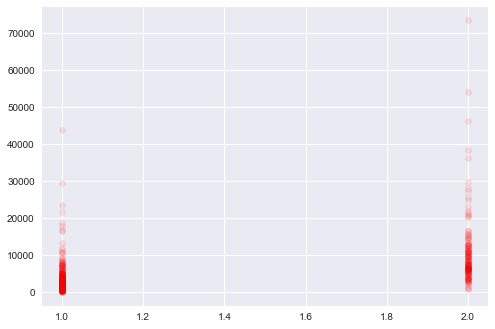

In [28]:
"""Tensorflow 2.0 Implementation, using Mixture Density Networks"""

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

X = df[['Channel']].values
X = X.astype(np.float32)
y = df[['Milk']].values
y = y.astype(np.float32)

plt.plot(X, y, 'ro', alpha=0.1)
plt.show()

N = len(X)
N = X.shape[0]
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(N).batch(N)

In [29]:
l = 1  # no. of dimensions
k = 2  # no. of components

# Base layer
input = tf.keras.Input(shape=(l,))
layer = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(input)

# Parameter constraints
mu = tf.keras.layers.Dense((l * k), activation=None, name='mean_layer')(layer)
var_layer = tf.keras.layers.Dense(k, activation=None, name='dense_var_layer')(layer)
var = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(k,), name='variance_layer')(var_layer)
pi = tf.keras.layers.Dense(k, activation='softmax', name='pi_layer')(layer)

# Model compilation
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
baselayer (Dense)               (None, 50)           100         input_4[0][0]                    
__________________________________________________________________________________________________
dense_var_layer (Dense)         (None, 2)            102         baselayer[0][0]                  
__________________________________________________________________________________________________
pi_layer (Dense)                (None, 2)            102         baselayer[0][0]                  
____________________________________________________________________________________________

In [30]:
def pdf(y, mu, var):
    """PDF of component density."""
    value = tf.subtract(y, mu)**2
    value = (1/tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1/(2*var)) * value)
    return value

def mdn_loss(y_true, pi, mu, var):
    """Loss function of MDN."""
    out = pdf(y_true, mu, var)
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    return tf.reduce_mean(out)

In [31]:
@tf.function
def train_step(model, optimizer, train_x, train_y):
    with tf.GradientTape() as tape:
        pi_, mu_, var_ = model(train_x, training=True)
        loss = mdn_loss(train_y, pi_, mu_, var_)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

Print every 600 epochs
Epoch 0/6000: loss 23.02586555480957
Epoch 600/6000: loss 23.02586555480957
Epoch 1200/6000: loss 23.02586555480957
Epoch 1800/6000: loss 23.02586555480957
Epoch 2400/6000: loss 23.02586555480957
Epoch 3000/6000: loss 23.02586555480957
Epoch 3600/6000: loss 23.02586555480957
Epoch 4200/6000: loss 23.02586555480957
Epoch 4800/6000: loss 23.02586555480957
Epoch 5400/6000: loss 23.02586555480957


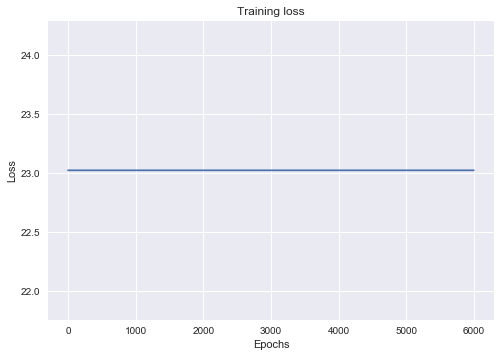

In [32]:
losses = []
EPOCHS = 6000
print_every = int(0.1 * EPOCHS)

model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()

print('Print every {} epochs'.format(print_every))
for i in range(EPOCHS):
    for train_x, train_y in dataset:
        loss = train_step(model, optimizer, train_x, train_y)
        losses.append(loss)
    if i % print_every == 0:
        print('Epoch {}/{}: loss {}'.format(i, EPOCHS, losses[-1]))
        

plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [33]:
def sample_predictions(pi_vals, mu_vals, var_vals, samples=10):
    n, k = pi_vals.shape
    # print('shape: ', n, k, l)
    # place holder to store the y value for each sample of each row
    out = np.zeros((n, samples, l))
    for i in range(n):
        for j in range(samples):
            # for each sample, use pi/probs to sample the index
            # that will be used to pick up the mu and var values
            idx = np.random.choice(range(k), p=pi_vals[i])
            for li in range(l):
                # Draw random sample from gaussian distribution
                out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+l)], np.sqrt(var_vals[i, idx]))
    return out    

pi_vals, mu_vals, var_vals = model.predict(X)
sampled_predictions = sample_predictions(pi_vals, mu_vals, var_vals, 10)

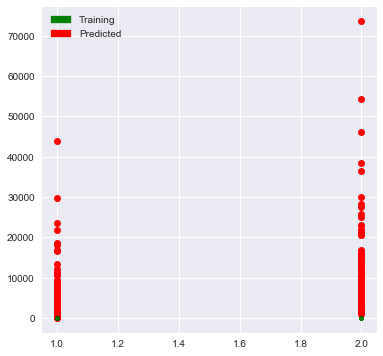

In [34]:
# Plot the predictions along with the flipped data 
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 6))
plt.plot(X, y, 'ro', label='train')
for i in range(sampled_predictions.shape[1]):
     plt.plot(X, sampled_predictions[:, i], 'g.', alpha=0.3, label='predicted')
patches = [
    mpatches.Patch(color='green', label='Training'),
    mpatches.Patch(color='red', label='Predicted')
]
    
plt.legend(handles=patches)
plt.show()

# Conditional Generative Adversarial Nets

In [29]:
import tensorflow as tf

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

from IPython import display

In [30]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [31]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

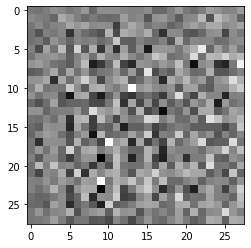

In [32]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [33]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [34]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00144047]], shape=(1, 1), dtype=float32)


In [35]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [40]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [45]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)

In [46]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

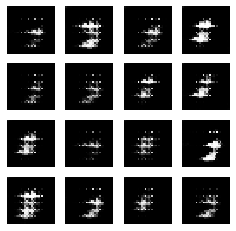

Time for epoch 2 is 216.93034839630127 sec


KeyboardInterrupt: 

In [47]:
train(train_dataset, EPOCHS)

# Probabilistic Graphical Model

Probabilistic Graphical Model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. Directed Graphical Models (DGMs) (or Bayesian Networks BNs) represent conditional dependencies between variables.

Structure learning methods of the PGM can be either constraint- or score-based.

Constraint-based structure learning use statistics tests to learn marginal/conditional independence relationships (or constraints) from the data and prune the graph-searching space using obtained constraints.

Score-based structure learning assigns each candidate Directed Acyclic Graph (DAG) a score reflecting the goodness of fit as the objective function to be optimised, and uses a global score such as BIC or Bayesian marginal likelihood to find structures that maximises the score.